# Day 4: Arbitrage Pricing Theory (APT)

---

### 🎯 Learning Objectives
- Understand APT theoretical framework
- Use Principal Component Analysis to identify factors
- Build a multi-factor APT model
- Compare statistical factors vs economic factors

---


### 📈 Why APT Matters| **Portfolio Construction** | Target specific factor tilts |

| **Alpha Generation** | Find unexplained returns |

**APT is more flexible than CAPM** - it doesn't specify WHICH factors matter.| **Hedging** | Know which factors to hedge |

| **Risk Decomposition** | Identify hidden factor exposures |

### Key Formula|-------------|---------------|

$$E[R_i] = R_f + \sum_{k=1}^{K} \beta_{ik} \lambda_k$$| Application | How APT Helps |



Where $\lambda_k$ is the risk premium for factor $k$### Trading Applications



### APT vs CAPM| Factors | Observable | Statistical/Economic |

| Assumptions | Mean-variance | Fewer restrictions |

| Aspect | CAPM | APT || Derivation | Equilibrium | No-arbitrage |

|--------|------|-----|| Factors | Single (Market) | Multiple (unspecified) |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. APT vs CAPM Theoretical Background

### 🎯 Key Differences for Trading

| Aspect | CAPM | APT |
|--------|------|-----|
| Factors | Single (Market) | Multiple (unspecified) |
| Derivation | Equilibrium | No-arbitrage |

| Assumptions | Mean-variance | Fewer restrictions |**Statistical factors (PCA) are often better at explaining returns, but economic factors are more interpretable and actionable.**

| Factors | Observable | Statistical/Economic |

### Trading Insight

### Two Approaches to APT Factors

| **Statistical** | Data-driven (PCA) | Principal components |

| Approach | Description | Example || **Economic** | Prespecified macro factors | Inflation, GDP, rates |
|----------|-------------|--------|

## 2. Extract Statistical Factors via PCA

| 3-5 factors | Practical for most equity portfolios |

### 🎯 Why PCA for Factor Discovery?| Scree plot | Elbow method |

| 90% variance | Cumulative threshold |

**PCA finds the factors that explain the most variance in returns.**| Eigenvalue > 1 | Kaiser criterion |

|---------------|----------|

| Component | What It Usually Represents || Rule of Thumb | Guidance |

|-----------|---------------------------|

| PC1 | Market factor (~50-70% variance) |### How Many Factors?

| PC2 | Industry/sector rotation |

| PC3 | Size or value tilt || PC4+ | Increasingly idiosyncratic |

In [2]:
# Standardize returns
scaler = StandardScaler()
returns_std = scaler.fit_transform(returns)

# Apply PCA - use min of 5 or available features
n_components = min(5, returns.shape[1])
pca = PCA(n_components=n_components)
factors_pca = pca.fit_transform(returns_std)

# Convert to DataFrame
factor_names = [f'PC{i+1}' for i in range(n_components)]
factors_df = pd.DataFrame(factors_pca, index=returns.index, columns=factor_names)

# Variance explained
var_explained = pca.explained_variance_ratio_
cum_var = np.cumsum(var_explained)

print("\n" + "="*60)
print("PCA VARIANCE EXPLAINED")
print("="*60)
print(f"{'Factor':<10} {'Variance %':<15} {'Cumulative %':<15}")
print("-"*40)
for i in range(n_components):
    print(f"PC{i+1:<9} {var_explained[i]*100:<15.2f} {cum_var[i]*100:<15.2f}")


PCA VARIANCE EXPLAINED
Factor     Variance %      Cumulative %   
----------------------------------------
PC1         58.20           58.20          
PC2         21.85           80.05          
PC3         8.45            88.49          
PC4         6.99            95.48          
PC5         4.52            100.00         


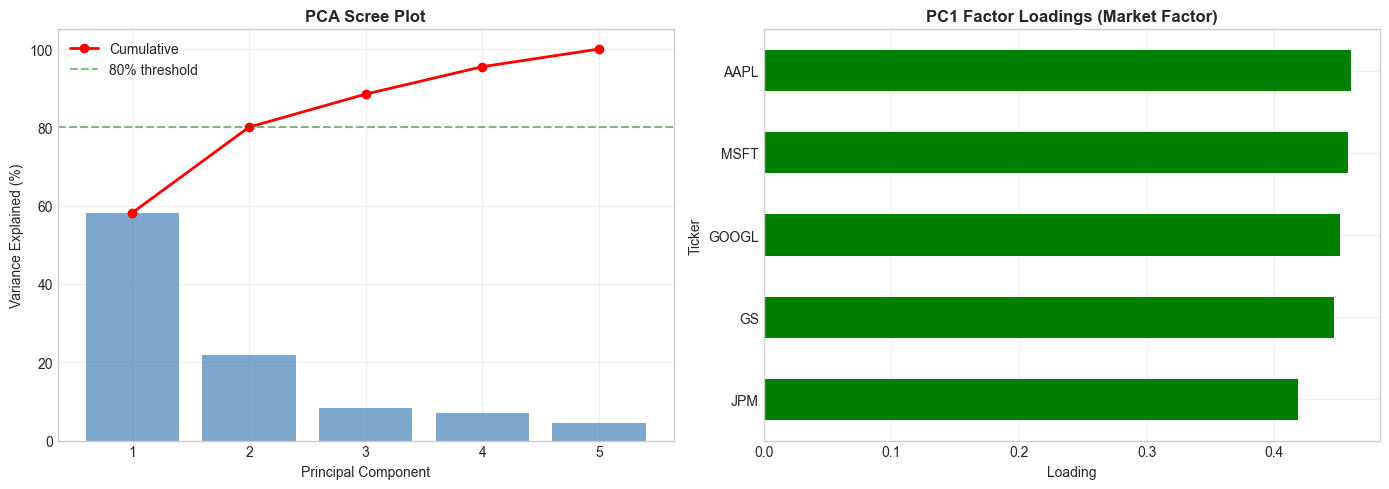


💡 PC1 typically represents the market factor with similar loadings across stocks


In [3]:
# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax1 = axes[0]
ax1.bar(range(1, n_components + 1), var_explained * 100, color='steelblue', alpha=0.7)
ax1.plot(range(1, n_components + 1), cum_var * 100, 'ro-', linewidth=2, label='Cumulative')
ax1.axhline(80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('PCA Scree Plot', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Factor loadings for PC1
ax2 = axes[1]
loadings = pd.Series(pca.components_[0], index=returns.columns).sort_values()
colors = ['red' if x < 0 else 'green' for x in loadings]
loadings.plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('Loading')
ax2.set_title('PC1 Factor Loadings (Market Factor)', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 PC1 typically represents the market factor with similar loadings across stocks")

## 3. Run APT Regression

In [4]:
def run_apt_regression(stock_returns, factors, n_factors=5):
    """Run APT regression with specified number of PCA factors."""
    daily_rf = RISK_FREE_RATE / TRADING_DAYS
    excess_returns = stock_returns - daily_rf
    
    X = sm.add_constant(factors.iloc[:, :n_factors])
    model = sm.OLS(excess_returns, X).fit()
    
    return model

# Test with different numbers of factors
test_stocks = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']

print("\n" + "="*60)
print("APT REGRESSION: VARYING NUMBER OF FACTORS")
print("="*60)

results = []
for n_factors in [1, 3, 5, 7, 10]:
    print(f"\n{n_factors} Factors:")
    print(f"{'Stock':<10} {'R²':<10} {'Alpha':<12}")
    print("-"*35)
    
    for stock in test_stocks:
        if stock in returns.columns:
            model = run_apt_regression(returns[stock], factors_df, n_factors)
            alpha = model.params['const'] * TRADING_DAYS
            
            results.append({
                'stock': stock,
                'n_factors': n_factors,
                'r2': model.rsquared,
                'alpha': alpha
            })
            
            print(f"{stock:<10} {model.rsquared:<10.4f} {alpha:<12.2%}")


APT REGRESSION: VARYING NUMBER OF FACTORS

1 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       0.6152     10.42%      
MSFT       0.6101     13.34%      
GOOGL      0.5931     24.90%      
JPM        0.5104     16.82%      
GS         0.5811     24.76%      

3 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       0.9464     10.42%      
MSFT       0.7775     13.34%      
GOOGL      0.9265     24.90%      
JPM        0.8928     16.82%      
GS         0.8815     24.76%      

5 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       1.0000     10.42%      
MSFT       1.0000     13.34%      
GOOGL      1.0000     24.90%      
JPM        1.0000     16.82%      
GS         1.0000     24.76%      

7 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       1.0000     10.42%      
MSFT       1.0000     13.34%      
GOOGL      1.0000     24.90%  

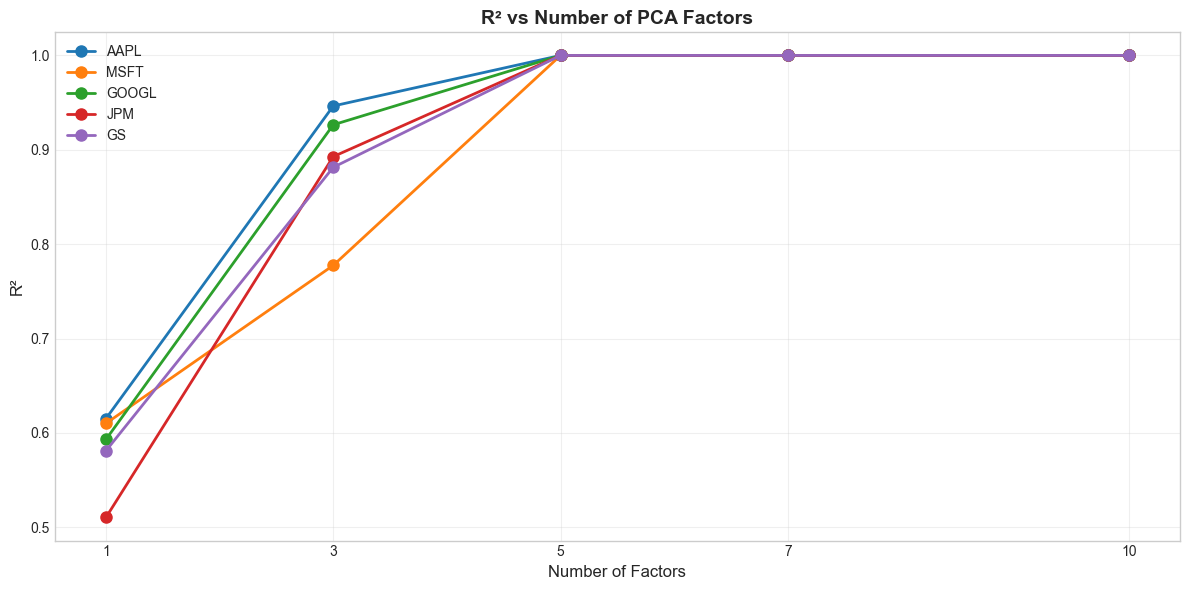


💡 R² increases with more factors, but be cautious of overfitting!


In [5]:
# Visualize R² vs number of factors
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 6))

for stock in test_stocks:
    stock_data = results_df[results_df['stock'] == stock]
    ax.plot(stock_data['n_factors'], stock_data['r2'], 'o-', linewidth=2, label=stock, markersize=8)

ax.set_xlabel('Number of Factors', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('R² vs Number of PCA Factors', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks([1, 3, 5, 7, 10])

plt.tight_layout()
plt.show()

print("\n💡 R² increases with more factors, but be cautious of overfitting!")

## 4. Factor Interpretation

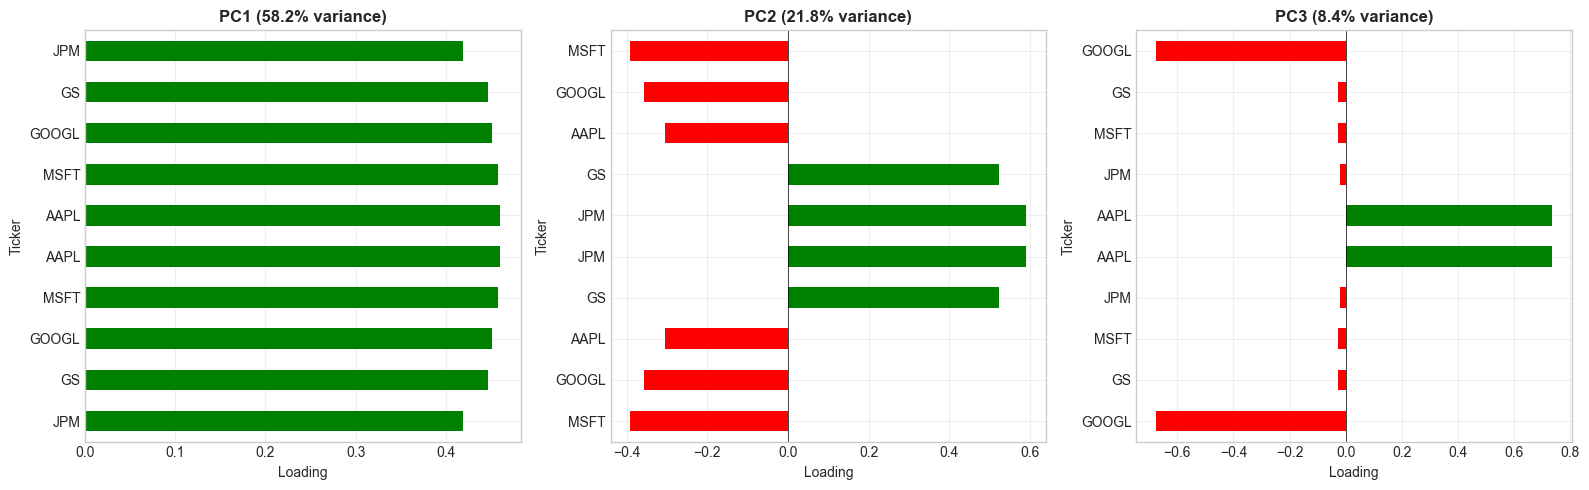


📊 Factor Interpretation:
   PC1: Usually the market factor (all loadings similar)
   PC2-3: Often sector or style factors


In [6]:
# Analyze top 3 factors
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    loadings = pd.Series(pca.components_[i], index=returns.columns)
    
    # Get top and bottom 5 stocks
    top5 = loadings.nlargest(5)
    bottom5 = loadings.nsmallest(5)
    
    combined = pd.concat([bottom5, top5])
    colors = ['red' if x < 0 else 'green' for x in combined]
    
    combined.plot(kind='barh', ax=ax, color=colors)
    ax.set_xlabel('Loading')
    ax.set_title(f'PC{i+1} ({var_explained[i]*100:.1f}% variance)', fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Factor Interpretation:")
print("   PC1: Usually the market factor (all loadings similar)")
print("   PC2-3: Often sector or style factors")

In [7]:
# Correlate PCA factors with market returns
market_proxy = returns['AAPL']

print("\n" + "="*50)
print("PCA FACTORS vs MARKET RETURNS CORRELATION")
print("="*50)
print(f"{'Factor':<10} {'Correlation':<15}")
print("-"*25)

for i in range(5):
    corr = np.corrcoef(factors_df[f'PC{i+1}'], market_proxy)[0, 1]
    print(f"PC{i+1:<9} {corr:<15.4f}")

print("\n💡 High PC1-Market correlation confirms PC1 ≈ Market Factor")


PCA FACTORS vs MARKET RETURNS CORRELATION
Factor     Correlation    
-------------------------
PC1         0.7843         
PC2         -0.3205        
PC3         0.4781         
PC4         -0.2312        
PC5         -0.0117        

💡 High PC1-Market correlation confirms PC1 ≈ Market Factor


## 5. APT Model Selection

In [8]:
# Use information criteria for model selection
print("\n" + "="*60)
print("MODEL SELECTION: AIC/BIC")
print("="*60)

model_selection = []

for stock in test_stocks:
    if stock in returns.columns:
        print(f"\n{stock}:")
        print(f"{'Factors':<10} {'R²':<10} {'AIC':<12} {'BIC':<12}")
        print("-"*45)
        
        for n_factors in [1, 3, 5, 7, 10]:
            model = run_apt_regression(returns[stock], factors_df, n_factors)
            print(f"{n_factors:<10} {model.rsquared:<10.4f} {model.aic:<12.2f} {model.bic:<12.2f}")
            
            model_selection.append({
                'stock': stock,
                'n_factors': n_factors,
                'r2': model.rsquared,
                'aic': model.aic,
                'bic': model.bic
            })

model_df = pd.DataFrame(model_selection)

print("\n💡 Lower AIC/BIC is better - balances fit vs complexity")


MODEL SELECTION: AIC/BIC

AAPL:
Factors    R²         AIC          BIC         
---------------------------------------------
1          0.6152     -7797.95     -7787.68    
3          0.9464     -10268.59    -10248.05   
5          1.0000     -95695.87    -95665.06   
7          1.0000     -95695.87    -95665.06   
10         1.0000     -95695.87    -95665.06   

MSFT:
Factors    R²         AIC          BIC         
---------------------------------------------
1          0.6101     -7967.10     -7956.83    
3          0.7775     -8667.46     -8646.92    
5          1.0000     -95674.74    -95643.93   
7          1.0000     -95674.74    -95643.93   
10         1.0000     -95674.74    -95643.93   

GOOGL:
Factors    R²         AIC          BIC         
---------------------------------------------
1          0.5931     -7441.36     -7431.09    
3          0.9265     -9585.13     -9564.59    
5          1.0000     -96308.67    -96277.86   
7          1.0000     -96308.67    -96277.86  

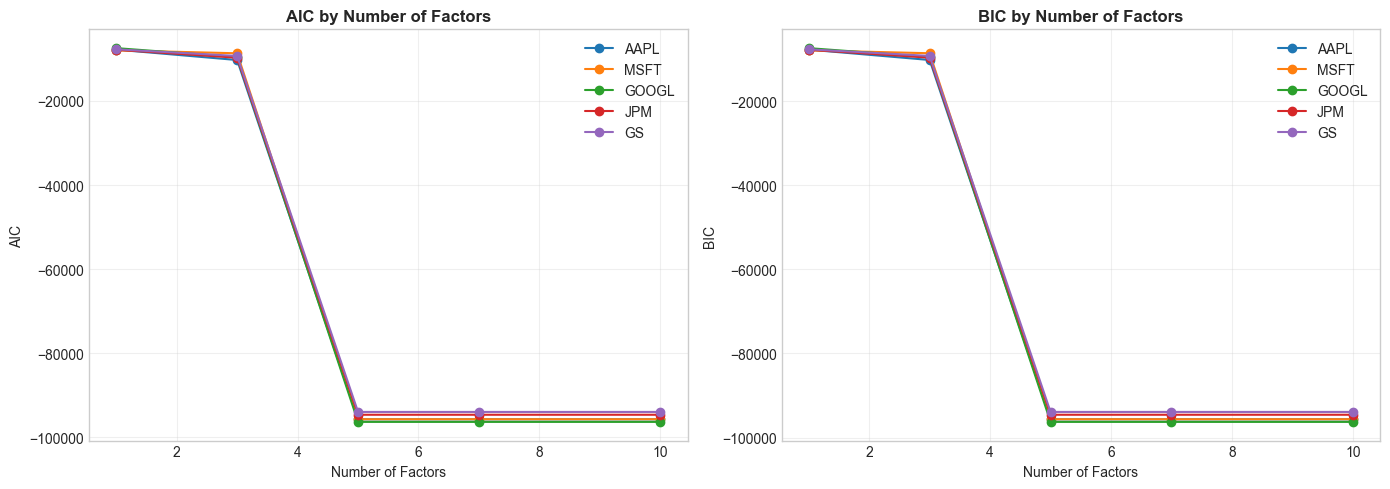

In [9]:
# Visualize AIC/BIC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AIC
ax1 = axes[0]
for stock in test_stocks:
    stock_data = model_df[model_df['stock'] == stock]
    ax1.plot(stock_data['n_factors'], stock_data['aic'], 'o-', label=stock)
ax1.set_xlabel('Number of Factors')
ax1.set_ylabel('AIC')
ax1.set_title('AIC by Number of Factors', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# BIC
ax2 = axes[1]
for stock in test_stocks:
    stock_data = model_df[model_df['stock'] == stock]
    ax2.plot(stock_data['n_factors'], stock_data['bic'], 'o-', label=stock)
ax2.set_xlabel('Number of Factors')
ax2.set_ylabel('BIC')
ax2.set_title('BIC by Number of Factors', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Statistical vs Economic Factors

In [10]:
print("\n" + "="*60)
print("STATISTICAL vs ECONOMIC FACTORS")
print("="*60)

print("""
STATISTICAL FACTORS (PCA-based):
✅ Advantages:
   - Data-driven, no prior assumptions
   - Maximizes variance explained
   - Orthogonal by construction

❌ Disadvantages:
   - Difficult to interpret economically
   - May not be stable over time
   - Sample-specific

ECONOMIC FACTORS (e.g., Fama-French):
✅ Advantages:
   - Clear economic interpretation
   - Stable, well-documented
   - Widely used in practice

❌ Disadvantages:
   - May not fully capture risk
   - Factors may be correlated
   - Requires fundamental data
""")


STATISTICAL vs ECONOMIC FACTORS

STATISTICAL FACTORS (PCA-based):
✅ Advantages:
   - Data-driven, no prior assumptions
   - Maximizes variance explained
   - Orthogonal by construction

❌ Disadvantages:
   - Difficult to interpret economically
   - May not be stable over time
   - Sample-specific

ECONOMIC FACTORS (e.g., Fama-French):
✅ Advantages:
   - Clear economic interpretation
   - Stable, well-documented
   - Widely used in practice

❌ Disadvantages:
   - May not fully capture risk
   - Factors may be correlated
   - Requires fundamental data



## Key Takeaways

1. **APT is more flexible** than CAPM - multiple factors
2. **PCA extracts statistical factors** that maximize variance
3. **PC1 ≈ Market factor** in most cases
4. **Model selection** (AIC/BIC) helps choose number of factors
5. **Tradeoff** between statistical fit and interpretability

---
*Next: Day 5 - Factor Exposure Analysis*

## 🔴 PROS & CONS: APT

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [11]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - APT Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 10:56

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
